# 自动微分与优化

有了自动微分以后，对一大类机器学习的求解会非常方便。首先考虑一个简单的线性模型：

In [2]:
import math
import numpy as np
import torch

np.random.seed(123456)
torch.manual_seed(123456)
n = 100
p = 5

beta = torch.randn(p)
x = torch.randn(n, p)
y = torch.matmul(x, beta) + torch.randn(n) * math.sqrt(0.1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


我们将利用简单的梯度下降对 $\beta$ 进行优化。首先创建一个初始值并声明需要梯度：

In [3]:
bhat = torch.zeros(p)
bhat.requires_grad = True

编写损失函数：

In [4]:
def loss_fn(bhat, x, y):
    yhat = torch.matmul(x, bhat)
    return torch.mean(torch.square(y - yhat))

建立一个循环用来不断更新参数：

In [5]:
# 迭代次数
nepoch = 5000
# 学习率，即步长
learning_rate = 0.01
# 记录损失函数值
losses = []

for i in range(nepoch):
    loss = loss_fn(bhat, x, y)

    loss.backward()
    losses.append(loss.item())

    if i % 50 == 0:
        print(f"iteration {i}, loss = {loss.item()}, error = {torch.mean(torch.square(bhat - beta))}")

    with torch.no_grad():
        bhat -= learning_rate * bhat.grad
        
        # 清空梯度项
        bhat.grad = None

iteration 0, loss = 6.666600227355957, error = 1.300956130027771
iteration 50, loss = 0.889494001865387, error = 0.17852994799613953
iteration 100, loss = 0.20490001142024994, error = 0.031567562371492386
iteration 150, loss = 0.11406505852937698, error = 0.007916359230875969
iteration 200, loss = 0.09939470887184143, error = 0.0029288791120052338
iteration 250, loss = 0.09633126854896545, error = 0.001613738015294075
iteration 300, loss = 0.09553375095129013, error = 0.0012249459978193045
iteration 350, loss = 0.09529763460159302, error = 0.0011070544132962823
iteration 400, loss = 0.09522352367639542, error = 0.001072814455255866
iteration 450, loss = 0.09519965946674347, error = 0.0010642611887305975
iteration 500, loss = 0.09519195556640625, error = 0.0010630962206050754
iteration 550, loss = 0.09518943727016449, error = 0.0010637094965204597
iteration 600, loss = 0.09518859535455704, error = 0.0010645021684467793
iteration 650, loss = 0.09518834948539734, error = 0.001065116142854

画出损失函数值的图像：

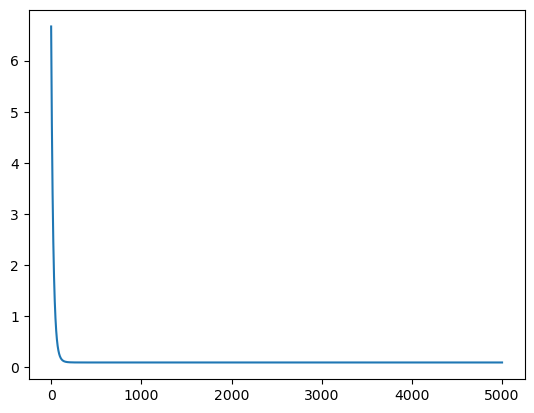

In [6]:
import matplotlib.pylab as plt
plt.plot(losses)

比较真实和估计的 $\beta$：

In [7]:
print(beta)
print(bhat)

tensor([ 1.8645,  0.4071, -1.1971,  0.3489, -1.1437])
tensor([ 1.8306,  0.4251, -1.2020,  0.3770, -1.0885], requires_grad=True)


# 模块化编程

PyTorch 中一种更常用的模型搭建和求解的方法是利用模块化编程，即将所有的参数装进一个类中，然后通过定义 `forward()` 函数来计算预测值。

In [8]:
import torch.nn as nn

class MyModel(nn.Module): # 从nn.Module中继承一些方法
    def __init__(self, beta_dim, w_dim): # 初始一些参数，需要传入beta的维度
        super(MyModel, self).__init__()
        self.bhat = nn.Parameter(torch.zeros(beta_dim)) # 所有加入nn.Para中的内容都令其为torch.zeros()
        self.w = nn.Parameter(torch.ones(w_dim))
        
        # nn.Para可以自动检测class中设置的参数内容

    def forward(self, x): # x是数据
        yhat = torch.matmul(x, self.bhat) # 这里是线性模型
        return yhat

np.random.seed(123456)
torch.random.manual_seed(123456)

model = MyModel(beta_dim=p,w_dim=(5,3)) # 根据MyModel创建了一个对象，并且传入了一些参数
print(list(model.parameters())) # 可以看到nn.Para自动将所有参数初始化了 #？这个model.parameters()是从哪里得到的？nn.Parameter吗还是nn.Module？

[Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)]


In [15]:
# 迭代次数
nepoch = 500000
# 学习率，即步长
learning_rate = 0.00001
# 记录损失函数值
losses = []

opt = torch.optim.SGD(model.parameters(), lr=learning_rate) # pytorch提供了一个优化器，对于model这个对象里的所有para进行优化

for i in range(nepoch):
    yhat = model(x)
    loss = torch.mean(torch.square(y - yhat))

    opt.zero_grad() # 梯度清零
    loss.backward() # 反向传播
    opt.step() # 

    losses.append(loss.item())

    if i % 50 == 0:
        print(f"iteration {i}, loss = {loss.item()}")

iteration 0, loss = 0.09518823772668839
iteration 50, loss = 0.09518823772668839
iteration 100, loss = 0.09518823772668839
iteration 150, loss = 0.09518823772668839
iteration 200, loss = 0.09518823772668839
iteration 250, loss = 0.09518823772668839
iteration 300, loss = 0.09518823772668839
iteration 350, loss = 0.09518823772668839
iteration 400, loss = 0.09518823772668839
iteration 450, loss = 0.09518823772668839
iteration 500, loss = 0.09518823772668839
iteration 550, loss = 0.09518823772668839
iteration 600, loss = 0.09518823772668839
iteration 650, loss = 0.09518823772668839
iteration 700, loss = 0.09518823772668839
iteration 750, loss = 0.09518823772668839
iteration 800, loss = 0.09518823772668839
iteration 850, loss = 0.09518823772668839
iteration 900, loss = 0.09518823772668839
iteration 950, loss = 0.09518823772668839
iteration 1000, loss = 0.09518823772668839
iteration 1050, loss = 0.09518823772668839
iteration 1100, loss = 0.09518823772668839
iteration 1150, loss = 0.095188237

KeyboardInterrupt: 

[Parameter containing:
tensor([ 1.8304,  0.4262, -1.1998,  0.3770, -1.0890], requires_grad=True)]


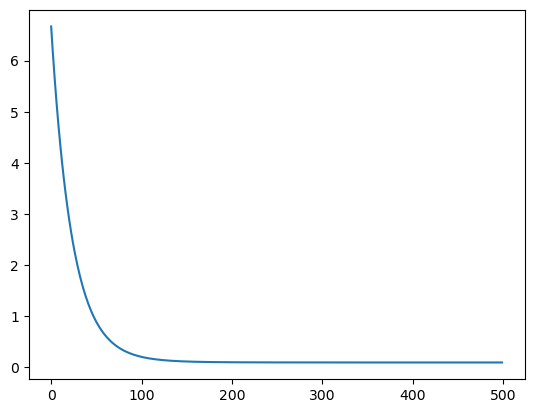

In [9]:
print(list(model.parameters()))
plt.plot(losses)

模块化编程的好处是模型的结构可以随时发生调整，而后续的循环、优化等部分的代码可以保持不变。例如，假设我们此时希望加入一个截距项，可以把模型修改为如下形式：

In [10]:
class MyModel(nn.Module):
    def __init__(self, beta_dim):
        super(MyModel, self).__init__()
        self.bhat = nn.Parameter(torch.randn(beta_dim))
        self.b0 = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        yhat = torch.matmul(x, self.bhat) + self.b0
        return yhat

np.random.seed(123456)
torch.random.manual_seed(123456)

model = MyModel(beta_dim=p)
print(list(model.parameters()))

[Parameter containing:
tensor([ 1.8645,  0.4071, -1.1971,  0.3489, -1.1437], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True)]


接下来模型训练的代码可以不做任何改变：

iteration 0, loss = 0.10102550685405731
iteration 50, loss = 0.09571389853954315
iteration 100, loss = 0.09518022835254669
iteration 150, loss = 0.0951167494058609
iteration 200, loss = 0.09510793536901474
iteration 250, loss = 0.09510650485754013
iteration 300, loss = 0.09510625153779984
iteration 350, loss = 0.09510622173547745
iteration 400, loss = 0.09510618448257446
iteration 450, loss = 0.09510619193315506
[Parameter containing:
tensor([ 1.8301,  0.4255, -1.2002,  0.3755, -1.0897], requires_grad=True), Parameter containing:
tensor([0.0094], requires_grad=True)]


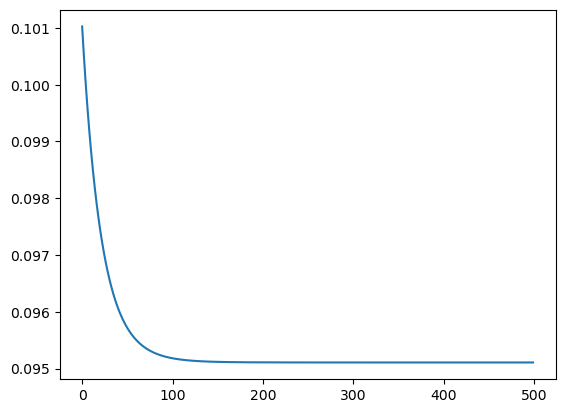

In [11]:
# 迭代次数
nepoch = 500
# 学习率，即步长
learning_rate = 0.01
# 记录损失函数值
losses = []

opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

for i in range(nepoch):
    yhat = model(x)
    loss = torch.mean(torch.square(y - yhat))

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

    if i % 50 == 0:
        print(f"iteration {i}, loss = {loss.item()}")

print(list(model.parameters()))
plt.plot(losses)